In [ ]:
!pip install -q -U kaggle_environments

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

Функция для получения результата игры

In [ ]:

def get_score(left_move, right_move):
    # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

1 Функция имитирующая Камень.

In [ ]:
def rock(observation, configuration):
    return 0


2 Функция имитирующая Бумагу.

In [ ]:
def paper(observation, configuration):
    return 1

3 Функция имитирующая Ножницы

In [ ]:

def scissors(observation, configuration):
    return 2

4 Функция копирующая предидущий ход оппонента

In [ ]:
def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

5 Функция которая смотрит последний ход соперника и предполагает что следущий ход будет таким же.

In [ ]:
last_react_action = None


def reactionary(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

6 Функция которая предполагает что соперник использует стратегию описанную в предидущей функции

In [ ]:
last_counter_action = None


def counter_reactionary(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

7 Последняя строка возвращает действие, которое побеждает наиболее частое действие противника. Для этого ищется Мода.

In [ ]:
action_histogram = {}


def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

8 Функция с произвольными значениями

In [ ]:
random_val = None

def randomazer(observation, configuration):
    global random_val
    random_val = random.randint(0, 2)

    return random_val

9 Чередование всех элементов

In [ ]:
action = None

def alternation(observation, configuration):
    global action
    if observation.step == 0:
        action = 0
    elif observation.step % configuration.signs == 0:
        action = 0
    else:
        action = (action + 1) % configuration.signs

    return action

10 Чередование элементов с большим шагом

In [ ]:
slow_action = None

def slow(observation, configuration):
    global slow_action
    if observation.step == 0:
        slow_action = 0
    elif observation.step % 33 == 0:
        slow_action = (slow_action + 1) % configuration.signs

    return slow_action


11 Фунция чередующая камень -ножницы

In [ ]:
rock_scis = None

def rock_scis_seq(observation, configuration):
    global rock_scis
    if observation.step == 0 or rock_scis == 2:
        rock_scis = 0
    else:
        rock_scis = 2

    return rock_scis

12 Функция повторяющая заданную последовательность

In [ ]:
act = None
counter = 0
seq =[0, 2, 2, 1, 0, 1]

def sequense(observation, configuration):
    global act, counter, seq
    act = seq[counter]
    counter += 1
    if counter == len(seq):
        counter = 0

    return act

13 Функция которая повторяет предидущее значение в случае победы, в случае поражения, рандом.

In [ ]:
victory = None


def last_victory(observation, configuration):
    global victory
    if observation.step == 0:
        victory = random.randrange(0, configuration.signs)
    elif get_score(victory, observation.lastOpponentAction) != 1:
        victory = random.randrange(0, configuration.signs)

    return victory


Создаем словарь для использования в турнире

In [ ]:
agents = {
    "rock": rock,
    "paper": paper,
    "scissors": scissors,
    "copy_opponent": copy_opponent,
    "reactionary": reactionary,
    "counter_reactionary": counter_reactionary,
    "statistical": statistical,
    "randomazer" : randomazer,
    "alternation": alternation,
    "slow" : slow,
    "rock_scis_seq": rock_scis_seq,
    "sequense": sequense,
    "last_victory": last_victory
}

Создаем турнир

In [ ]:
results_1 = dict(zip(tuple(agents.keys()), (0 for i in range(len(agents)))))
results_2 = results_1.copy()


opponenets = list(agents.keys()) # список соперников, который будет убавляться
for first in agents.keys():
    opponenets.remove(first)
    for second in opponenets:
        competition = evaluate(
            "rps", #environment to use - no need to change
            [agents[first], agents[second]], #agents to evaluate
            configuration={"episodeSteps": 100})
        if competition[0][0] > 0:
            results_2[first] += competition[0][0]
        if competition[0][1] > 0:
            results_2[second] += competition[0][1]
        results_1[first] += competition[0][0]
        results_1[second] += competition[0][1]









In [ ]:
results1 = sorted(results_1.items(), key = lambda x: x[1], reverse=True)   # Результаты учитывающие победы и поражения
results2 = list(filter(lambda x: x[1] != 0, sorted(results_2.items(), key = lambda x: x[1], reverse=True))) # Результаты учитывающие только победы

Строим круговую диаграмму по результатам набранных очков только за победы.

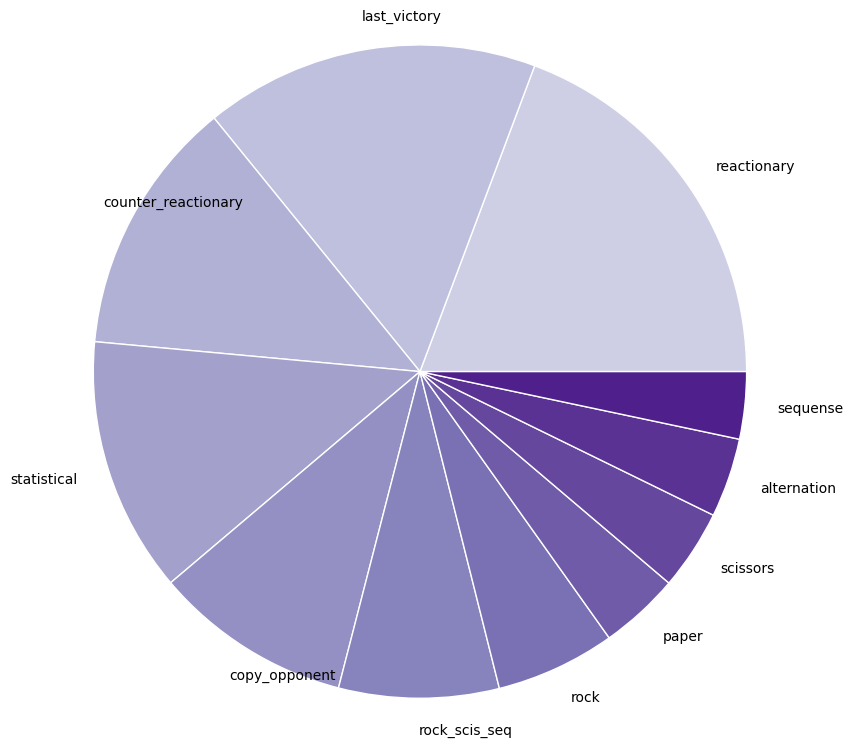

In [ ]:

plt.style.use('_mpl-gallery-nogrid')

names = [i[0] for i in results2]
# make data
x = [i[1] for i in results2]
colors = plt.get_cmap('Purples')(np.linspace(0.3, 0.9, len(x)))

# plot
fig, ax = plt.subplots()
ax.pie(x, colors=colors, labels=names, radius=10, center=(10, 10),
       wedgeprops={"edgecolor": "white"}, frame=False)

ax.set(xlim=(2, 8),
       ylim=(2, 8))

plt.show()


Строим Диаграмму учитывающую как победы так и поражения

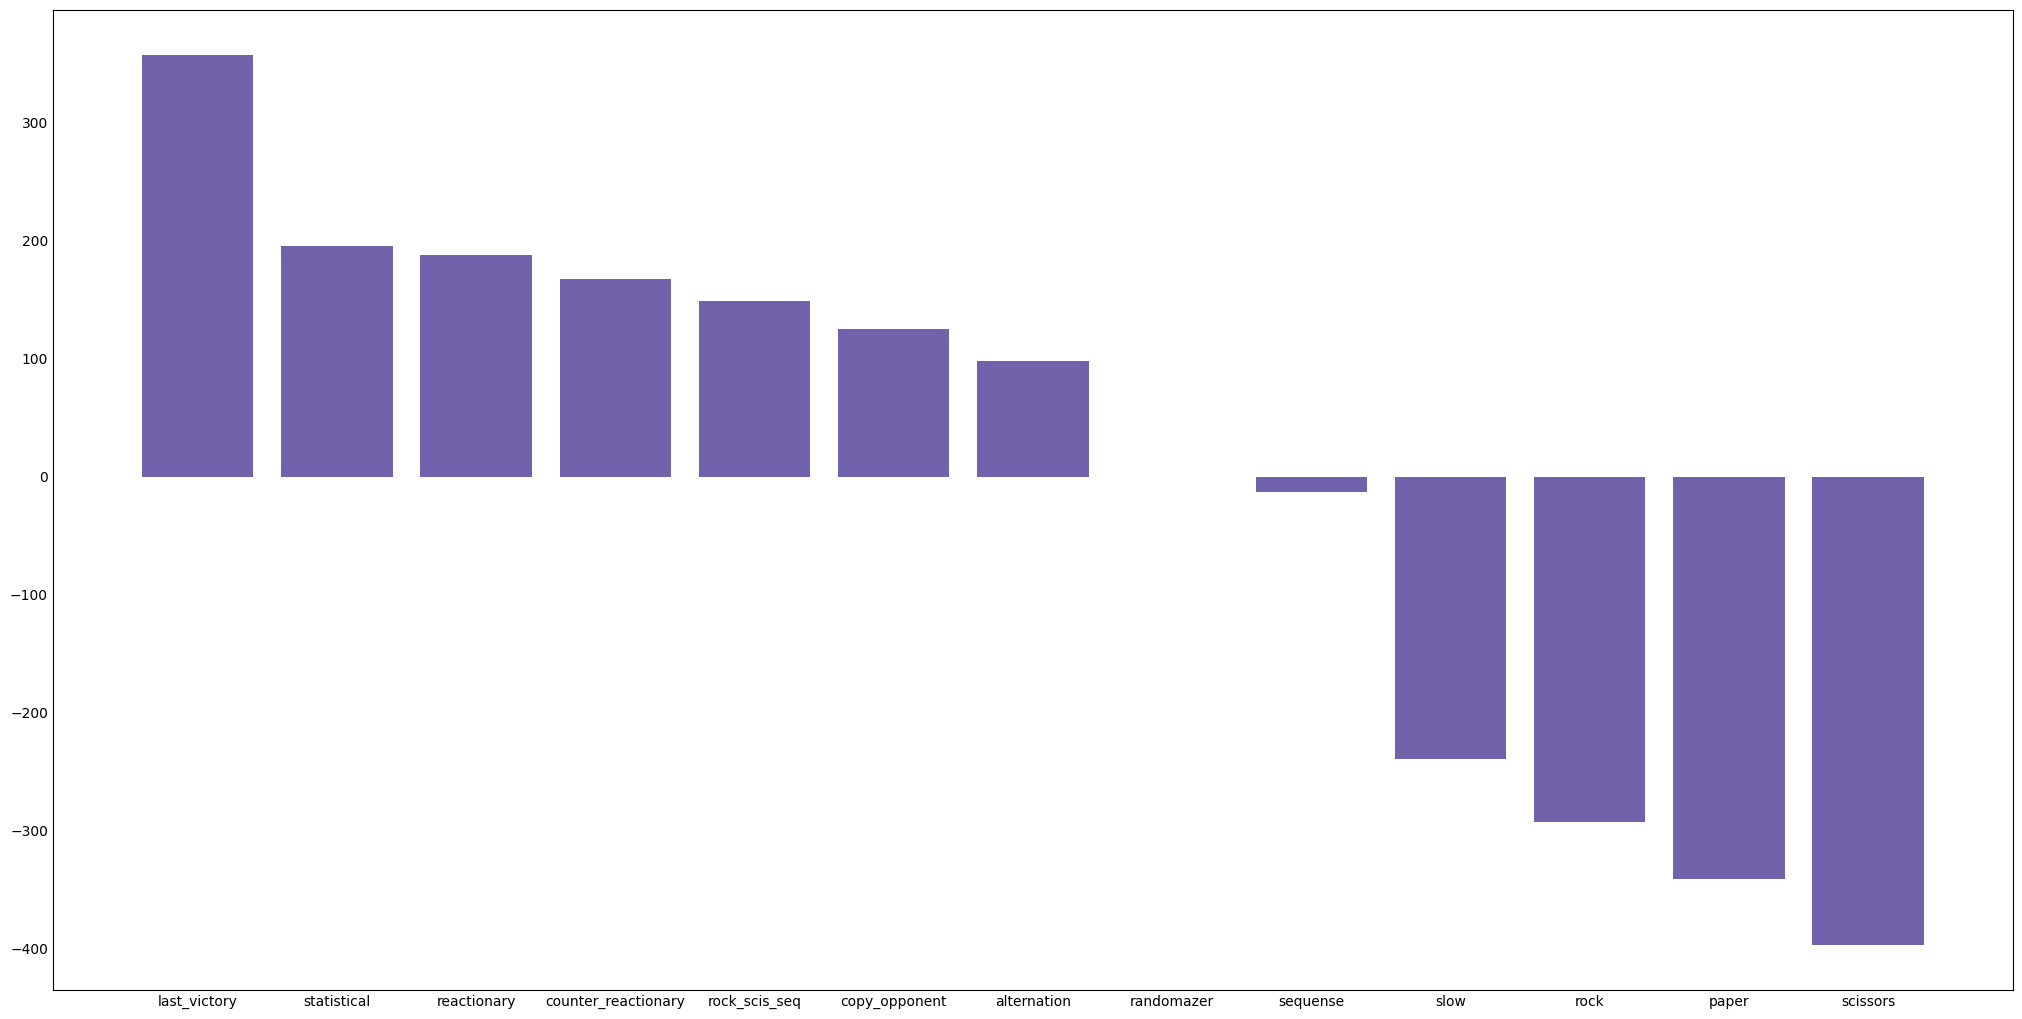

In [ ]:
# Значения на оси x и y
names = [i[0] for i in results1]
values = [i[1] for i in results1]
colors = plt.get_cmap('Purples')(np.linspace(0.7, 0.7))
# Размер графика и его отображение
plt.figure(figsize=(20, 10))
plt.bar(names, values, color=colors)
plt.show()

Попробуем теперь использовать информацию о прошлых действиях противника. Опишем агента, который производит то же самое действие, что и оппонент на прошлом ходу